## Не изменяйте данный файл! Его функция - описать блоки кода и возможности этого скрипта, а также показать решения возможных часто встречающихся проблем. Для генерации графиков для конкретного НТ создайте скрипт на основе этого.
Все данные о конкретном тестовом прогоне вносятся во второй блок. Внимательно читайте инструкции по заполнению ниже.

### Переменные, их назначение и особенности заполнения
* CSV_NAME - название csv, который выдал jmeter.
* CSV_PATH - название папки с csv.
* IMG_PATH - название папки, в которую складываются итоговые графики.
* IMG_PREFIX - префикс, добавляемый к генерируемым графикам.
* SCENARIO_NAME - название пройденного сценария, используется в названии графика.
* TIME_UNIT - единица измерения времени. Определяет величину, в которой будет измеряться время на шкале X на графиках и в переменной DELIMITERS.
* DELIMITERS - список временных отметок для разделения этапов подачи нагрузки.

> Примечание: вполне вероятно, что при отрисовке графиков для конкретных прогонов не удаствся получить красивую картинку со значениями параметров по умолчанию. В этом случае обратитесь к документации функции graph: там довольно много настроек, которые позволяют обрезать и кастомизировать внешний вид графика.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import os
from enum import Enum

In [2]:
# Глобальные переменные, их менять не нужно:
plt.rcParams['agg.path.chunksize'] = 10000
TIMESTAMP = 'timeStamp'
RESPONSE_CODE = 'responseCode'
LABEL = 'label'
LATENCY = 'Latency'
ALL_THREADS = 'allThreads'
TIME = 'time'
fields = [TIMESTAMP, RESPONSE_CODE, LABEL, LATENCY, ALL_THREADS]
list_code = ['200', '201', '400', '401', '404', '405', '409', '502', '500']


class TimeUnit(Enum):
    MILLISECONDS = "мс", 0.1,
    SECONDS = "с", 1,
    MINUTES = "мин", 60,
    HOURS = "ч", 60 * 60

    def __init__(self, symbol: str, divider: int) -> None:
        self.symbol = symbol
        self.divider = divider

In [3]:
# Глобальные переменные, их менять можно/нужно:
CSV_NAME = 'openSchedule_example_script_221116_v2'
CSV_PATH = 'csvs'
IMG_PATH = 'img'
IMG_PREFIX = 'j_'
SCENARIO_NAME = 'Просмотр расписания'
TIME_UNIT = TimeUnit.MINUTES
DELIMITERS = [5, 15, 18]

##### Просмотр списка статус кодов. Убедиться, что нет одинаковых строковых и числовых статусов кодов

In [4]:
csv_df_not_time_corrected = pd.read_csv(CSV_PATH + '/' + CSV_NAME + '.csv',
                                        sep=',', skipinitialspace=True, usecols=fields)
csv_df_not_time_corrected[RESPONSE_CODE].unique()

array([200., 500.,  nan])

In [5]:
csv_df_not_time_corrected[RESPONSE_CODE] = csv_df_not_time_corrected[RESPONSE_CODE].map(
    lambda response_code: int(response_code) if response_code in list_code else response_code)
csv_df_not_time_corrected[RESPONSE_CODE].unique()

array([200., 500.,  nan])

In [6]:
def time_correct(df):
    """
    Добавляет новый столбец в dataframe. Необходимо для того, чтобы зафиксировать нулевую точку отсчета на графике
    :param df: преобразуемый dataframe
    """
    min_value = df[TIMESTAMP].min()
    df[TIME] = df[TIMESTAMP].map(lambda time_stamp: (time_stamp - min_value) / 1000)
    return df


csv_df = time_correct(csv_df_not_time_corrected)

In [43]:
# Общие методы для рисования графиков

def draw_delimiters(plt, delimiters, start=0, color='#000000', vertical=True):
    if vertical:
        for delimiter in delimiters:
            plt.axvline(x=start + delimiter, color=color)
    else:
        for delimiter in delimiters:
            plt.axhline(y=delimiter, color=color)
        

def draw_title(plt, title):
    plt.title(title, fontsize=80)
    
    
def draw_ticks(plt, x_start, x_end, x_tick, y_start, y_end, y_tick):
    size = 30
    plt.xticks(np.arange(x_start, x_end, x_tick), size=size)
    plt.yticks(np.arange(y_start, y_end, y_tick), size=size)
    
    
def draw_labels(plt, x_label, y_label):
    size = 60
    plt.xlabel(x_label, fontsize=size)
    plt.ylabel(y_label, fontsize=size)

    
def save_to_file(plt, scenario_name, filename):
    if not os.path.exists(IMG_PATH):
        os.mkdir(IMG_PATH)
    plt.savefig(IMG_PATH + '/' + IMG_PREFIX + scenario_name + ', ' + filename + '.jpg')

In [48]:
def graph_latency(
        data_frame,
        graph_title=SCENARIO_NAME,
        v_delimiters=DELIMITERS,
        h_delimiters=[],
        top_margin=1000,
        x_tick=10,
        y_tick=5000,
        x_start=0,
        time_unit=TIME_UNIT,
        y_axis_format="%.0f"
):
    """
    Строит график по атрибуту Latency. Распределение на успешные коды зафиксировано статусом 200.
    Расширить, если дополнительно ожидаем 201.
    :param time_unit: единица измерения времени на оси X. По умолчанию берет значение глобальной переменной TIME_UNIT
    :param data_frame: data frame с данными мониторинга;
    :param graph_title: название графика;
    :param delimiters: x-координаты вертикальных линий для разграничения этапов НТ_скрипта;
    :param top_margin: отступ от верхней точки графика;
    :param x_tick: деления по оси x;
    :param y_tick: деления по оси y;
    :param x_start: начало графика по оси x;
    :param y_axis_format: формат подписей по оси y;
    """
    non_num_responses = list(filter(lambda a: isinstance(a, str), data_frame.dropna()[RESPONSE_CODE].unique().tolist()))
    num_only_items = data_frame[~data_frame[RESPONSE_CODE].isin(non_num_responses)]
    good = num_only_items[(num_only_items[RESPONSE_CODE] >= 200) & (num_only_items[RESPONSE_CODE] < 300)]
    bad = data_frame[~data_frame.isin(good)].dropna()

    ax, fig = plt.subplots(figsize=(80, 30))
    g1 = plt.scatter(good[TIME] / time_unit.divider, good[LATENCY], alpha=0.5, color='#00ff44')
    g2 = plt.scatter(bad[TIME] / time_unit.divider, bad[LATENCY], alpha=0.5, marker='v', color='#ff0015')

    max_lat = data_frame[LATENCY].max() * 0.8
    a = plt.gca()
    a.yaxis.set_major_formatter(ticker.FormatStrFormatter(y_axis_format))


    draw_delimiters(plt, start=x_start, delimiters=v_delimiters)
    draw_delimiters(plt, delimiters=h_delimiters, vertical=False)
    draw_title(plt, 'Latency, ' + graph_title)
    draw_ticks(plt, x_start=x_start, x_end=data_frame[TIME].max() / time_unit.divider, x_tick=x_tick, 
               y_start=0, y_end=data_frame[LATENCY].max() + top_margin, y_tick=y_tick)
    draw_labels(plt, x_label="Время от начала теста, " + time_unit.symbol, y_label="Latency, мс")

    plt.legend(
        (g1, g2),
        ('Успешные статус коды', 'Остальные'),
        scatterpoints=3,
        loc='upper left',
        ncol=1,
        fontsize=40,
        markerscale=4.
    )
    plt.grid()
    save_to_file(plt, graph_title, 'latency')

In [45]:
def graph_active_threads(
        data_frame,
        graph_title=SCENARIO_NAME,
        v_delimiters=DELIMITERS,
        h_delimiters=[],
        top_margin=1000,
        x_tick=300,
        y_tick=1,
        x_start=0,
        time_unit=TIME_UNIT
):
    """
    Строит график по атрибуту active threads.
    :param time_unit: единица измерения времени на оси X. По умолчанию берет значение глобальной переменной TIME_UNIT
    :param data_frame: data frame с данными мониторинга;
    :param graph_title: название графика;
    :param delimiters: x-координаты вертикальных линий для разграничения этапов НТ_скрипта;
    :param top_margin: отступ от верхней точки графика;
    :param x_tick: деления по оси x;
    :param y_tick: деления по оси y;
    :param x_start: начало графика по оси x;
    """
    good = data_frame[(data_frame[RESPONSE_CODE] == 200)]
    ax, fig = plt.subplots(figsize=(80, 30))
    adjusted_time = data_frame[TIME] / time_unit.divider
    divider = 50 / time_unit.divider

    dop = np.arange(x_start, adjusted_time.max(), divider)
    x = []
    y = []
    for i in dop:
        y.append(len(data_frame[(adjusted_time > i) & (adjusted_time <= i + divider)][ALL_THREADS].unique()))
        x.append(i + divider)

    g1 = plt.plot(x, y, alpha=0.5, color='#00ff44', linewidth=5)

    draw_delimiters(plt, start=x_start, delimiters=v_delimiters)
    draw_delimiters(plt, delimiters=h_delimiters, vertical=False)
    draw_title(plt, 'Активные потоки в момент времени, ' + graph_title)
    draw_ticks(plt, x_start=x_start, x_end=adjusted_time.max(), x_tick=x_tick, 
               y_start=0, y_end=max(y) + top_margin, y_tick=y_tick)
    draw_labels(plt, x_label="Время от начала теста, " + time_unit.symbol, y_label='Активные потоки, кол-во')
    plt.grid()
    save_to_file(plt, graph_title, 'active_threads')

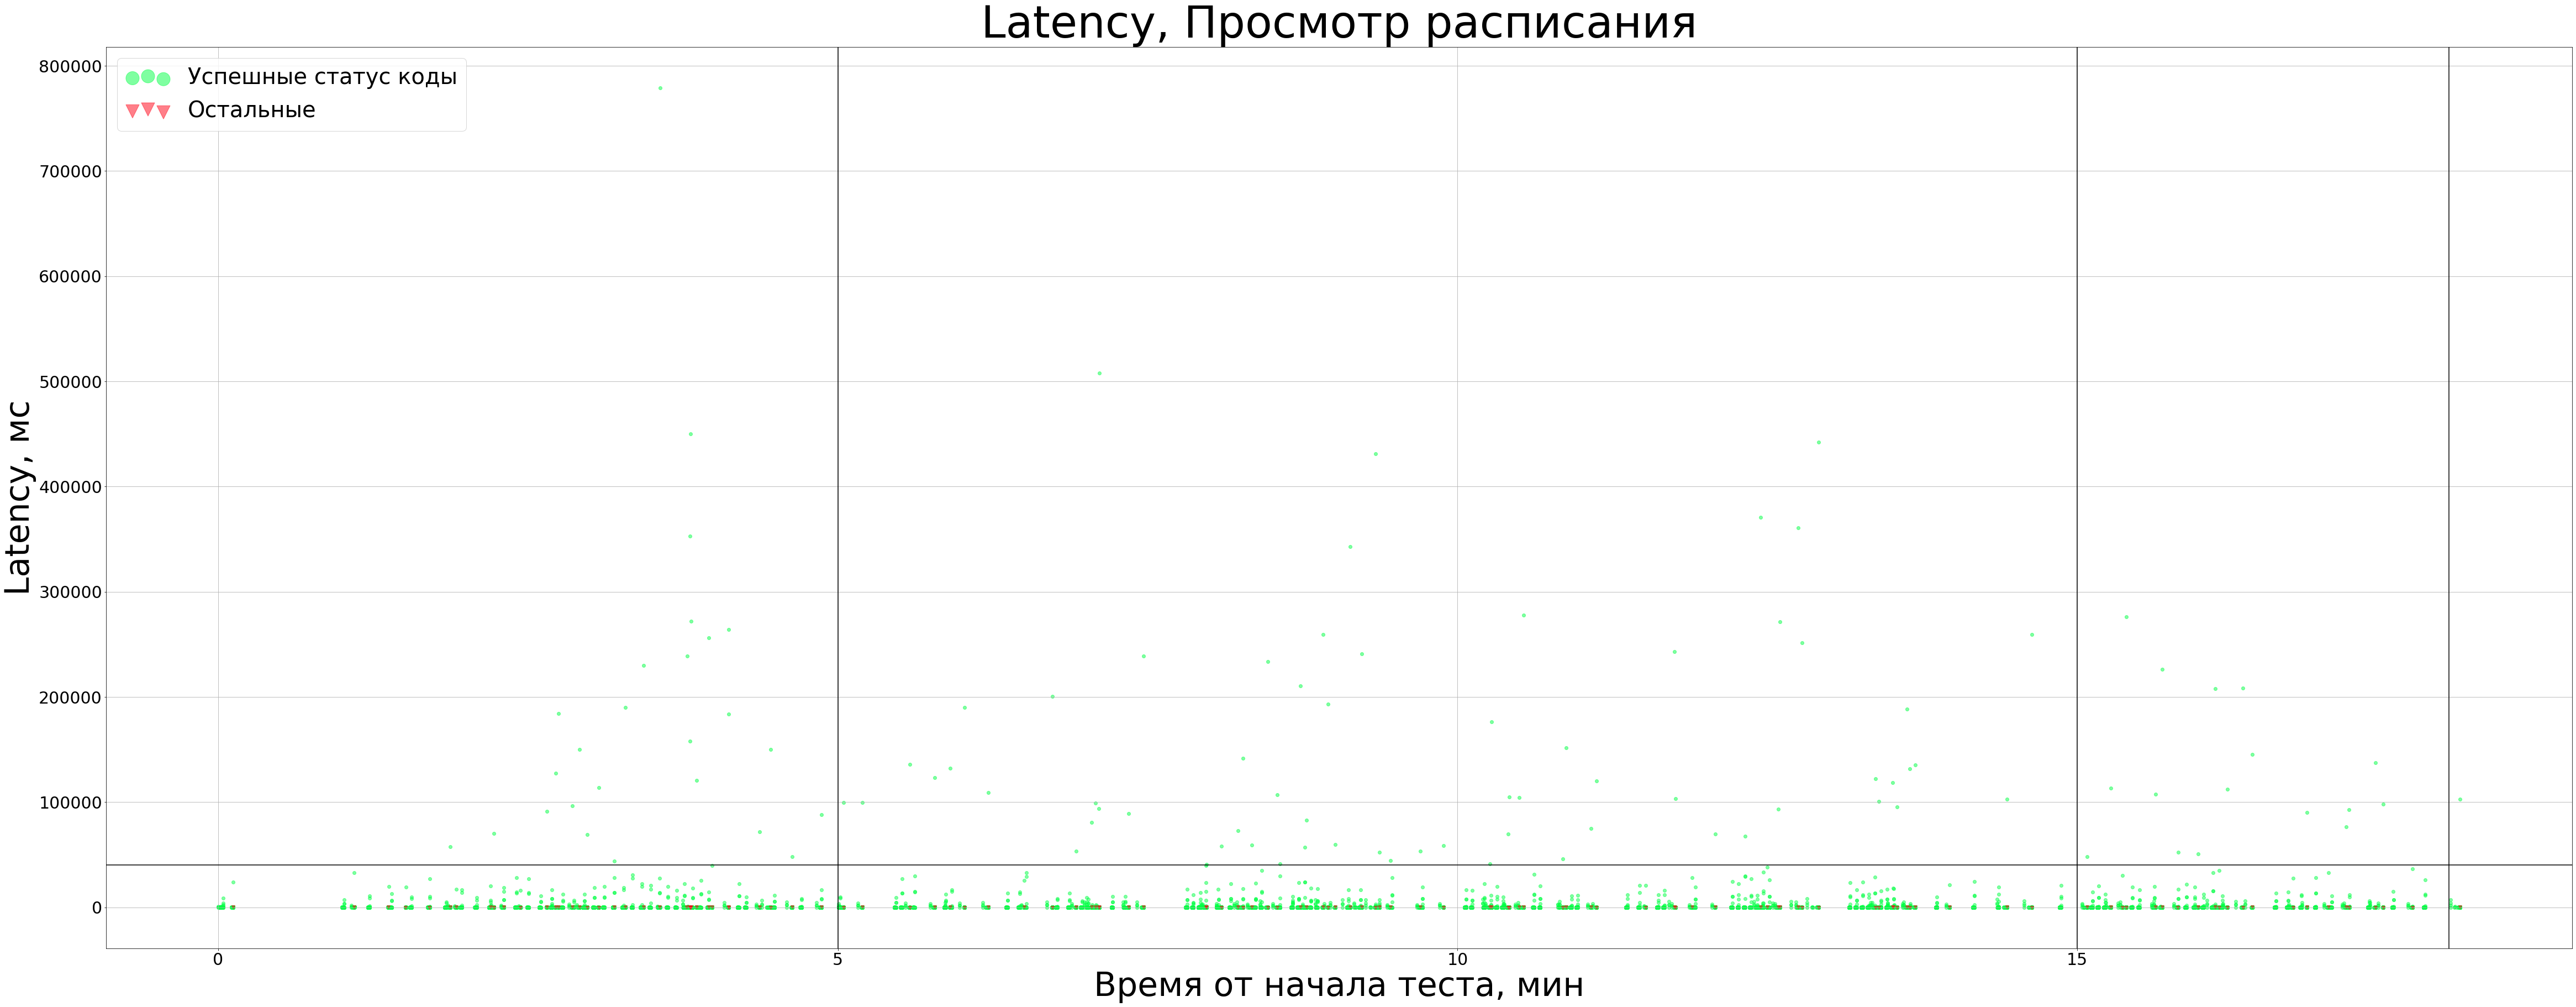

In [46]:
# Пример построения графика задержки
graph_latency(
    csv_df,
    h_delimiters=[csv_df[LATENCY].unique().mean()],
    x_tick=5,
    y_tick=100000,
    top_margin=csv_df[LATENCY].max() / 10,
)
# для top_margin мы берем 10% от максимального значения по шкале y, 
# чтобы сделать отступ между самим графиком и верхней границей зоны рисования графика

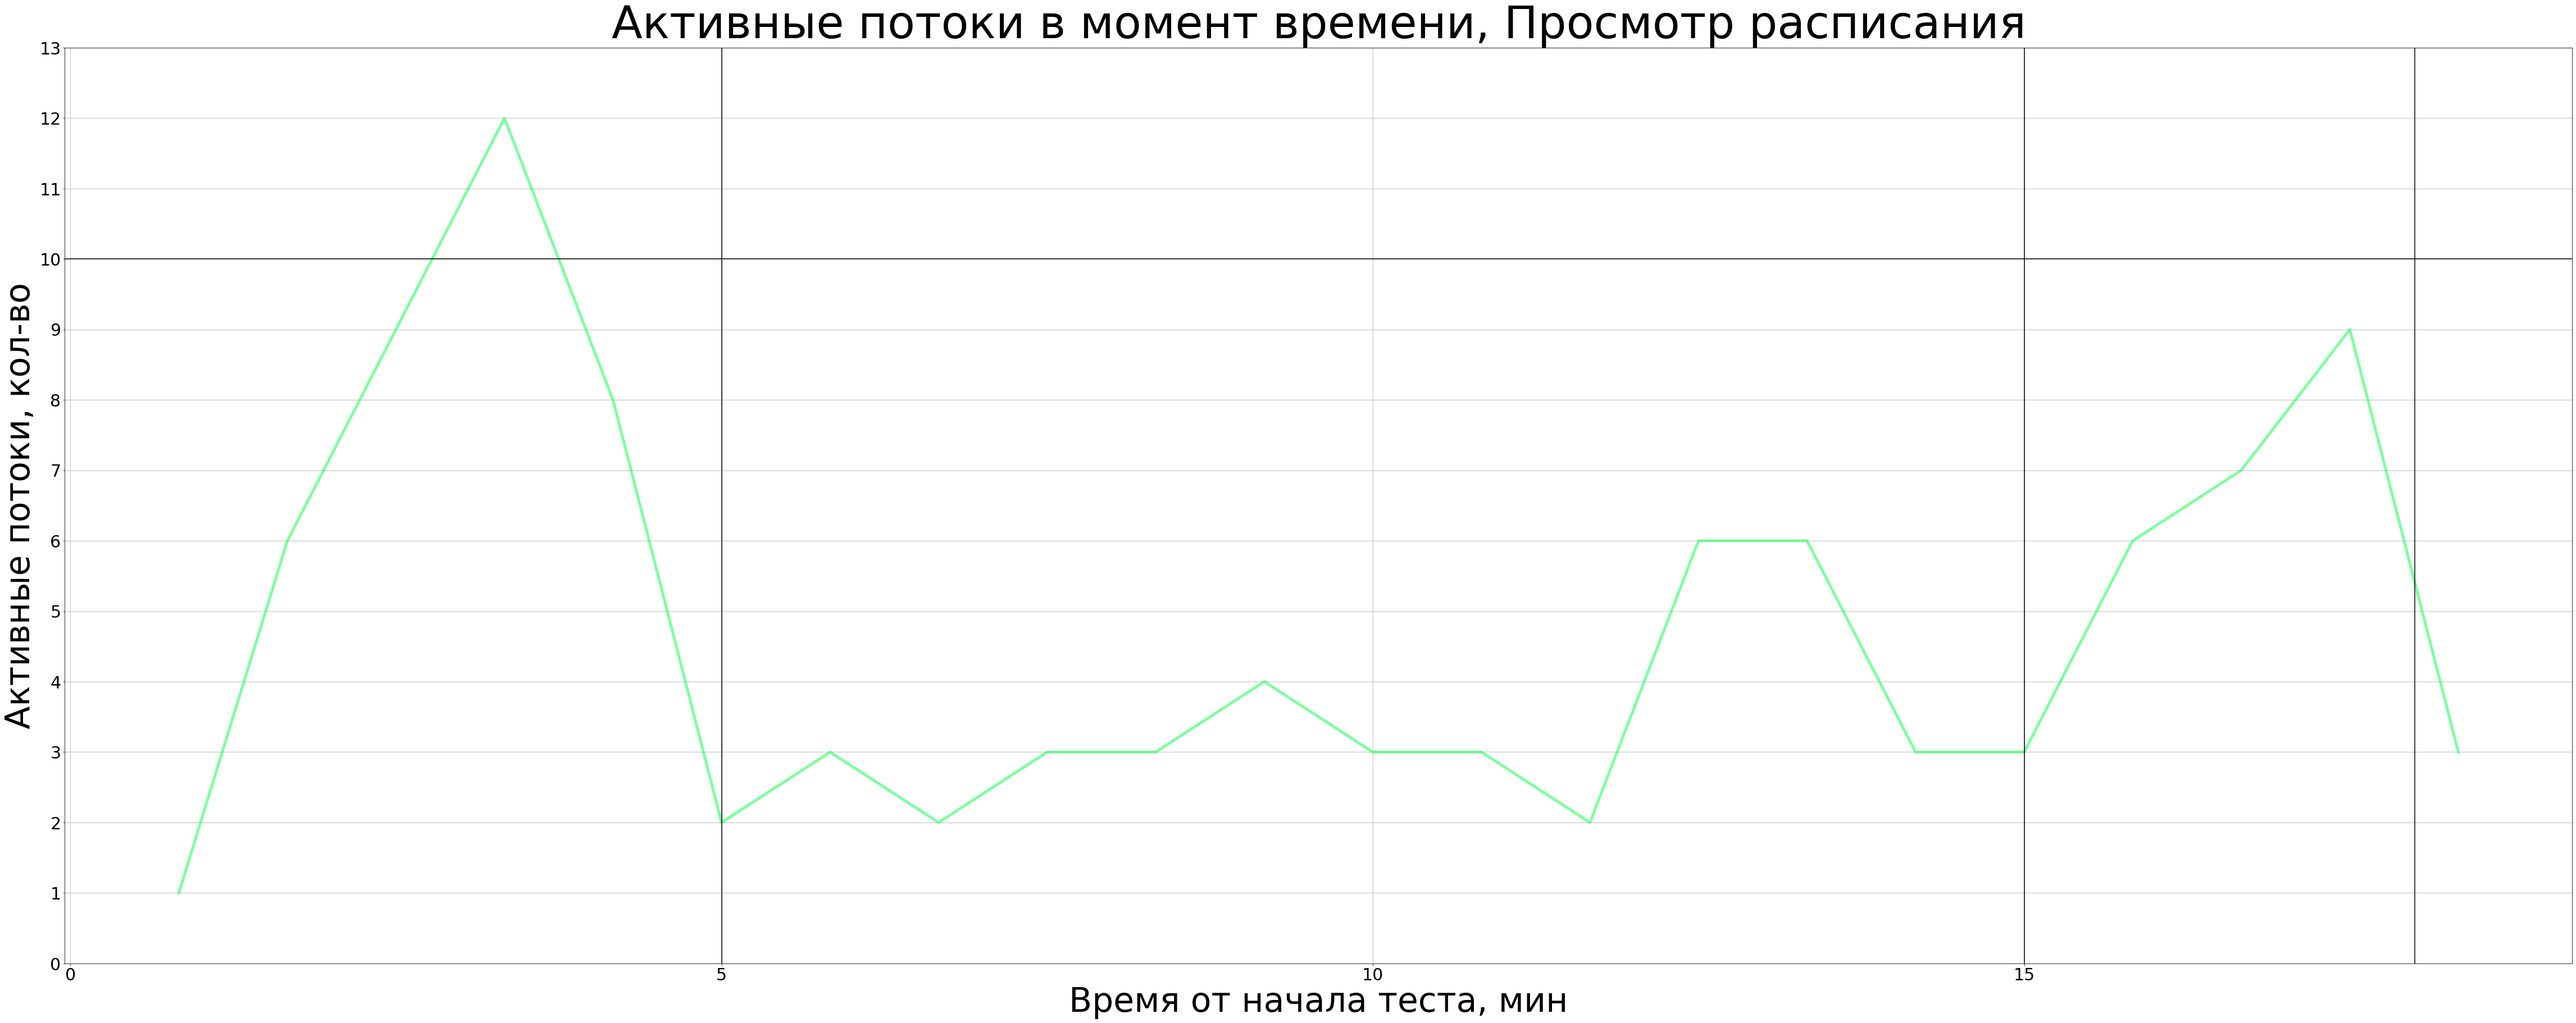

In [47]:
# Пример построения графика активных потоков
graph_active_threads(
    csv_df,
    h_delimiters=[csv_df[ALL_THREADS].unique().mean()],
    x_tick=5,
    y_tick=1,
    top_margin=csv_df[ALL_THREADS].max() / 10
)

##### Пример получения запросов с определенным лейблом

In [16]:
# Вспомогательная функция: получение всех имеющихся лейблов запросов
csv_df_not_time_corrected[LABEL].unique()  

array(['узнаем даты', 'Переход в ОМ', '/css/index.min.css', '/auth.js',
       '/dist/view-bundled.html', '/jspm_packages/system.js',
       '/config.js', '/dist/vendor-build.js', '/favicon.ico',
       '/dist/app-build.js',
       '/jspm_packages/npm/webcomponents.js@0.7.24/HTMLImports.min.js',
       '/locales/ru/translation.json', '/locales/en/translation.json',
       '/node_modules/material-design-lite/material.min.js',
       '/fonts/material-icons.woff', '/packages/slim/slim.amd.js',
       '/fonts/materialdesignicons-webfont.woff2?v=5.9.55',
       '/fonts/Roboto-Regular.ttf', '/fonts/Roboto-Medium.ttf',
       '/fonts/Roboto-MediumItalic.ttf',
       '/dist/modules/_shifts/indicators/shifts-histogram.mjs',
       '/dist/modules/_shifts/indicators/utilization-text.mjs',
       '/dist/modules/_shifts/indicators/shifts.mjs',
       '/dist/modules/_shifts/indicators/cost-hour.mjs',
       '/dist/modules/_shifts/indicators/base.mjs',
       '/dist/modules/_shifts/indicators/coating

In [17]:
df_slice_not_time_corrected = csv_df_not_time_corrected[(csv_df_not_time_corrected[LABEL] == 'Оргюнит')]
if not len(df_slice_not_time_corrected):
    raise ValueError("Нет данных")

In [21]:
# Вспомогательная функция: просмотр распределения атрибута (в данном случае latency) в столбце
df_slice_not_time_corrected[LATENCY].describe()

count    127.000000
mean      51.897638
std       14.748061
min       31.000000
25%       39.000000
50%       52.000000
75%       63.000000
max      112.000000
Name: Latency, dtype: float64

In [22]:
# Вспомогательная функция: просмотр среднего значения атрибута в столбце
df_slice_not_time_corrected[LATENCY].mean()

51.89763779527559

In [24]:
# Вспомогательная функция: распределение статус-кодов
def status_code_control(df):
    print('code', 'percent', 'l_count', 't_count', sep = '\t')
    df_length = len(df)
    temp_dict = {}
    for i in df[RESPONSE_CODE].unique():
        temp = df[(df[RESPONSE_CODE] == i)]
        percent = 100 * len(temp) / df_length
        print(str(i), str(percent), len(temp), df_length,  sep = '\t')
        temp_dict[i] = temp[LABEL].unique()
    print('----------------------')
    good = temp_dict.get(200)                   
status_code_control(csv_df_not_time_corrected)
a = csv_df_not_time_corrected['label'].unique()
for x in a:
    print(x)
    status_code_control(csv_df_not_time_corrected[(csv_df_not_time_corrected['label'] == x)])


code	percent
200.0	100.0
Req only errors


##### Пример поиска средних значений для каждой группы запросов

In [25]:
u_labels = csv_df[LABEL].unique()

In [26]:
for label in u_labels:
    lab = label
    lat = csv_df[(csv_df[LABEL] == label)][LATENCY].mean()
    print(int(lat), lab, sep='\t')

0	узнаем даты
28	Переход в ОМ
5	/css/index.min.css
3	/auth.js
4	/dist/view-bundled.html
5	/jspm_packages/system.js
4	/config.js
4	/dist/vendor-build.js
3	/favicon.ico
4	/dist/app-build.js
4	/jspm_packages/npm/webcomponents.js@0.7.24/HTMLImports.min.js
6	/locales/ru/translation.json
4	/locales/en/translation.json
4	/node_modules/material-design-lite/material.min.js
4	/fonts/material-icons.woff
4	/packages/slim/slim.amd.js
4	/fonts/materialdesignicons-webfont.woff2?v=5.9.55
5	/fonts/Roboto-Regular.ttf
4	/fonts/Roboto-Medium.ttf
4	/fonts/Roboto-MediumItalic.ttf
3	/dist/modules/_shifts/indicators/shifts-histogram.mjs
2	/dist/modules/_shifts/indicators/utilization-text.mjs
2	/dist/modules/_shifts/indicators/shifts.mjs
2	/dist/modules/_shifts/indicators/cost-hour.mjs
2	/dist/modules/_shifts/indicators/base.mjs
2	/dist/modules/_shifts/indicators/coating-fte.mjs
108	/build-info
3	/properties.json
2	/revision.json
4	/node_modules/moment/min/moment.min.js
4	/node_modules/lodash/lodash.min.js
4	/

##### Пример исключения из датафрейма запросов из предыдущего запуска теста (если результаты двух запусков были сохранены в один файл)

In [28]:
csv_df_cut_start = csv_df[csv_df[TIME] > 300]
csv_df_cut_start

,timeStamp,label,responseCode,allThreads,Latency,time
3931,1668584414794,узнаем даты,200.0,20,0,300.367
3932,1668584414796,Переход в ОМ,200.0,20,21,300.369
3933,1668584414817,/css/index.min.css,200.0,20,5,300.390
3934,1668584414840,/auth.js,200.0,20,4,300.413
3937,1668584414889,BeanShell Sampler,200.0,20,0,300.462
...,...,...,...,...,...,...
14293,1668585038142,4g,NaN,2,279672,923.715
14294,1668585027603,Запросы на бек расписание,NaN,2,297826,913.176
14295,1668584889124,История часов работы оргюнитов,200.0,1,442119,774.697
14296,1668584889113,4g,NaN,1,445658,774.686


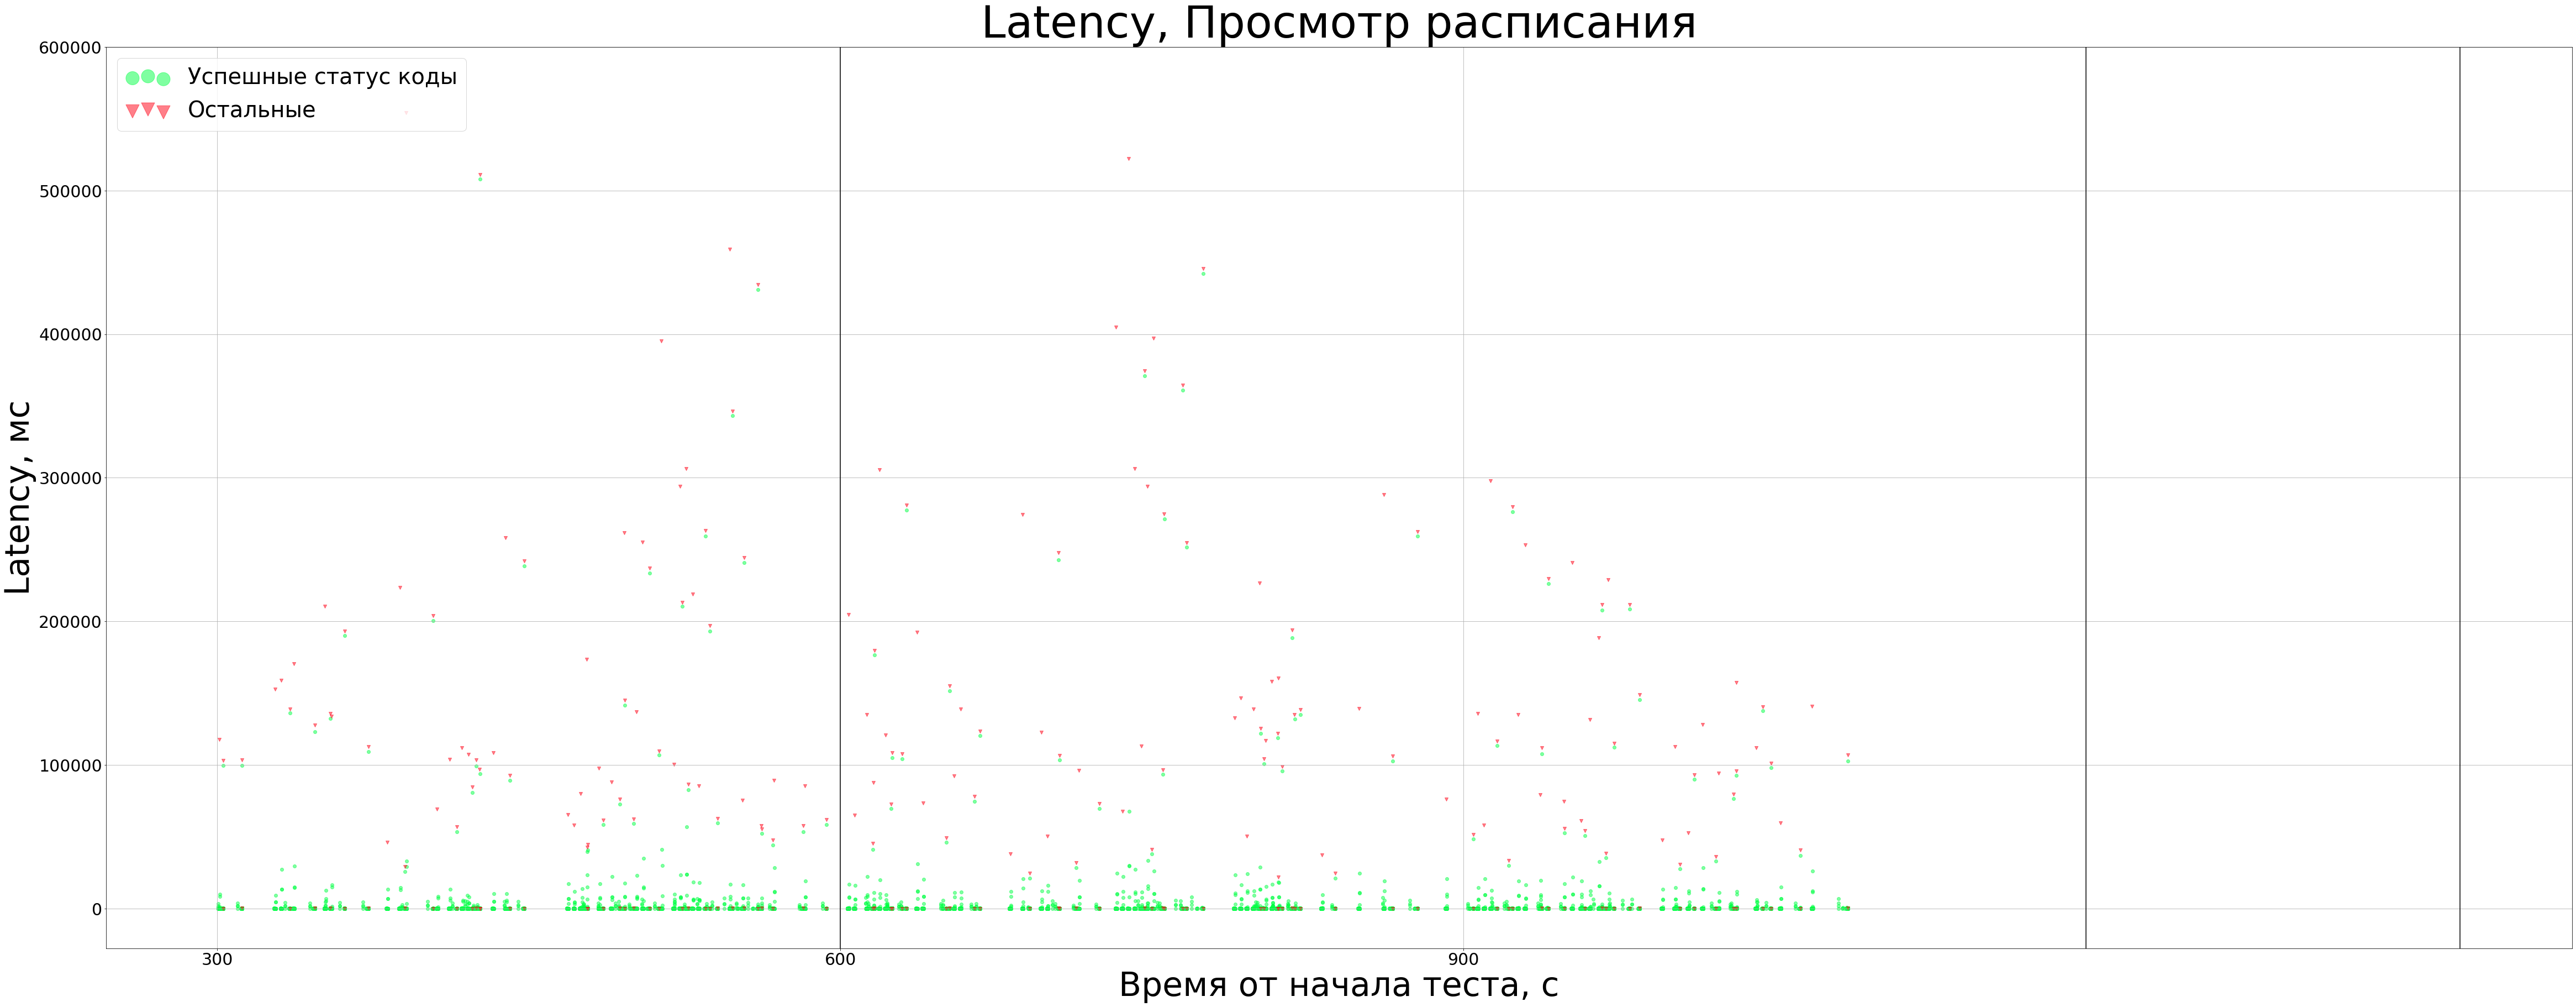

In [41]:
graph_latency(
    csv_df_cut_start,
    SCENARIO_NAME,
    "cut_" + SCENARIO_NAME,
    x_tick=300,
    y_tick=100000,
    x_start=300,
    top_margin=csv_df_cut_start[LATENCY].max() / 10,
    *DELIMITERS 
)

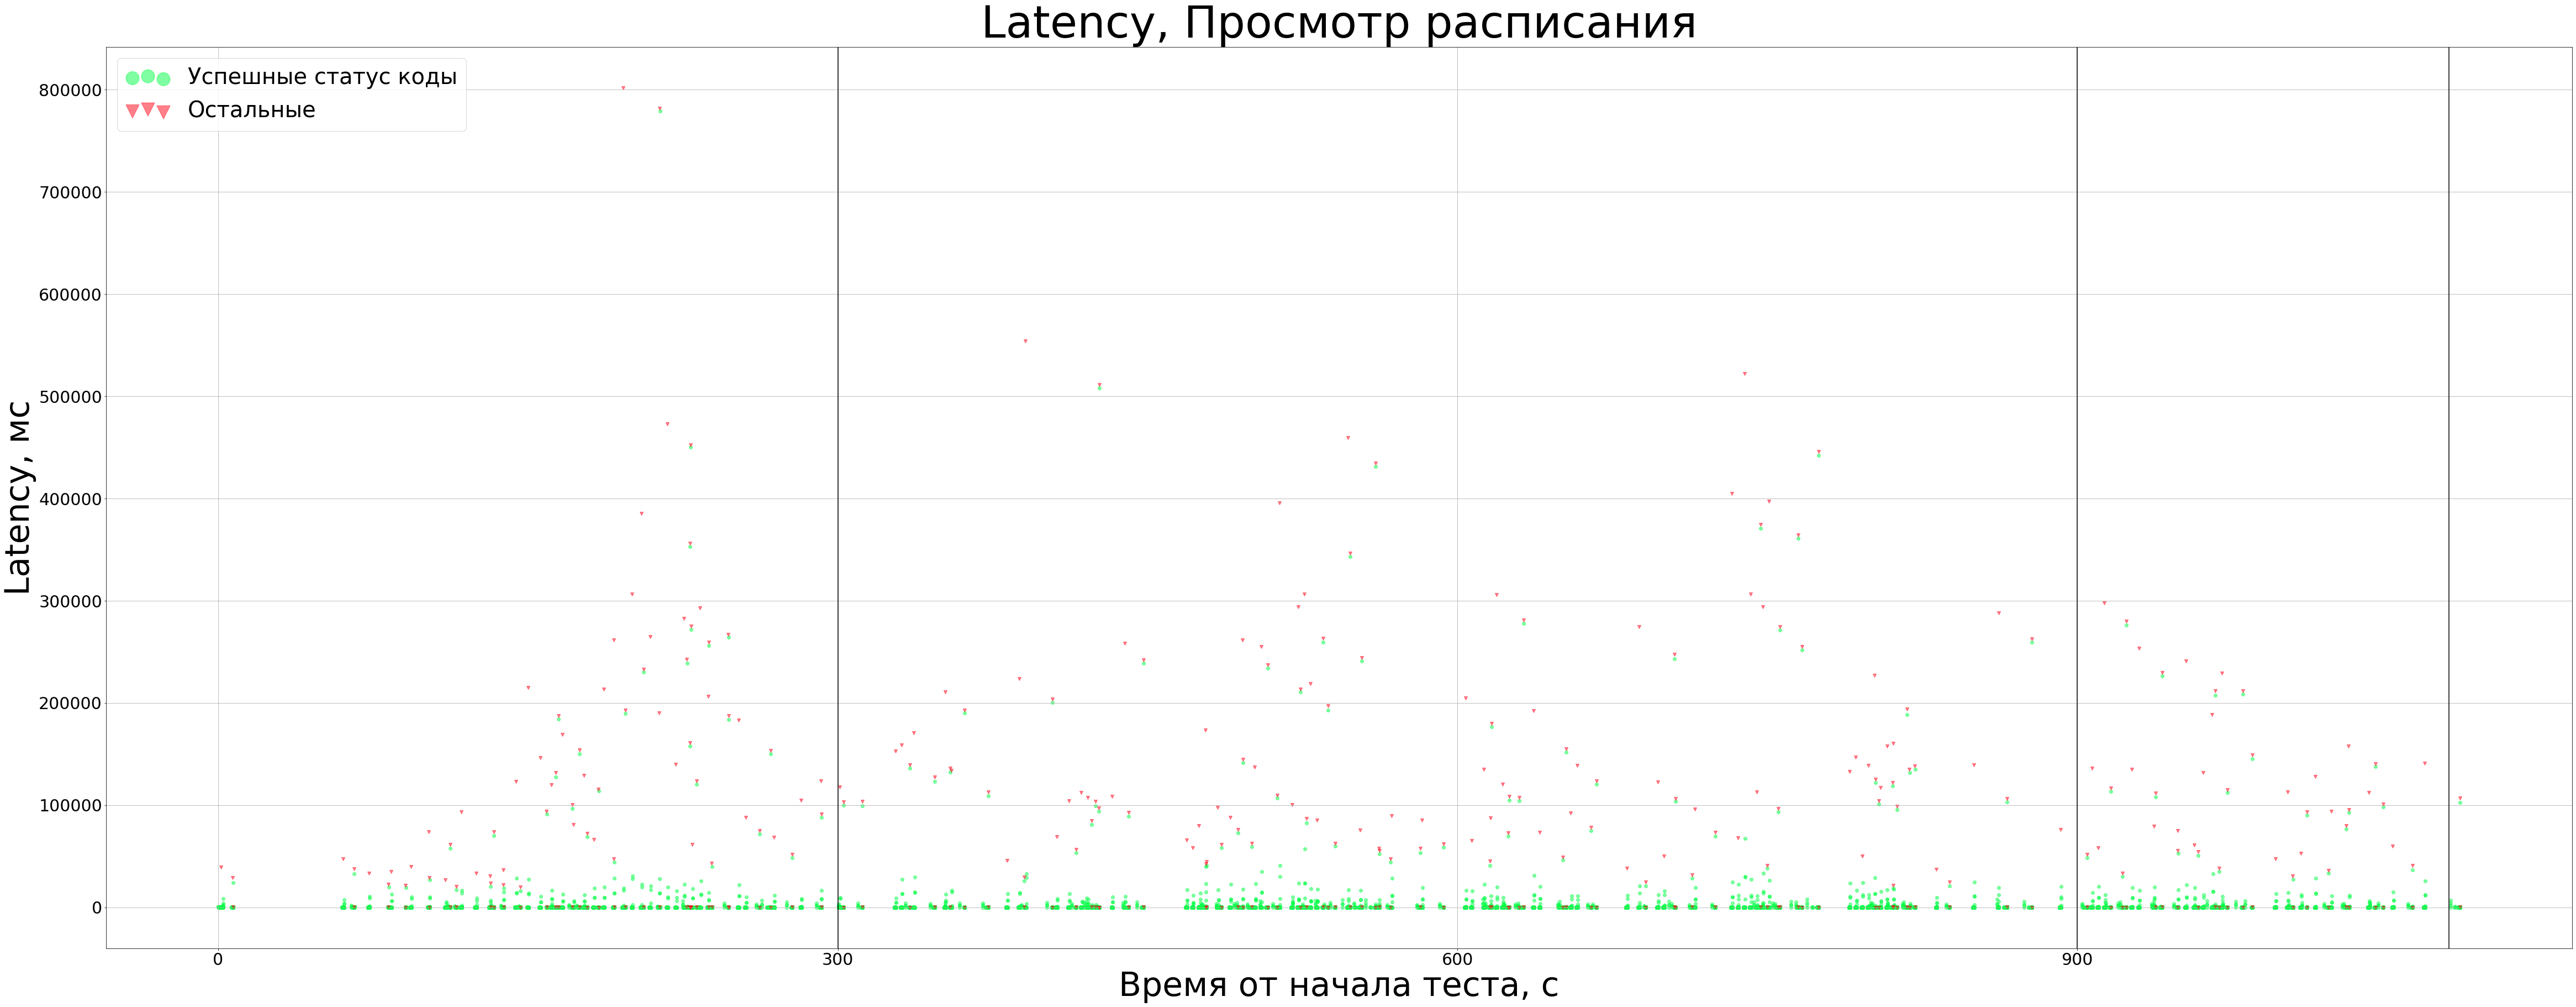

In [42]:
# Сравните с графиком, где первые запросы не были обрезаны
graph_latency(
    csv_df,
    SCENARIO_NAME,
    "uncut_" + SCENARIO_NAME,
    x_tick=300,
    y_tick=100000,
    top_margin=csv_df[LATENCY].max() / 10,
    *DELIMITERS
)